In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import sys
import src.SABR.sabr
reload(src.SABR.sabr)
from src.SABR.sabr import calibrate_sabr
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

<AxesSubplot: >

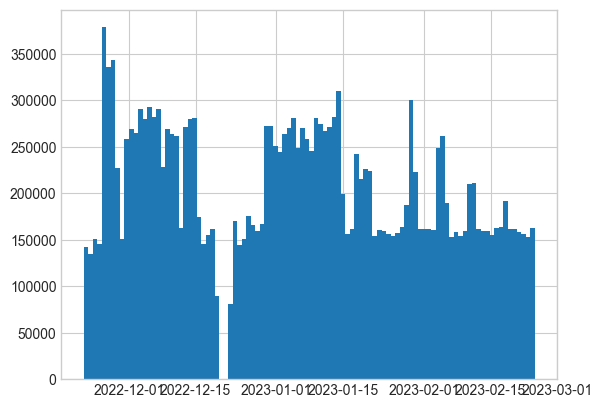

In [2]:
# heavy
# %%time
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
raw.dt.hist(bins = 100)

In [3]:
%%time
start = process_data(raw)

CPU times: user 49.6 s, sys: 19.1 s, total: 1min 8s
Wall time: 1min 19s


In [4]:
df = start.copy()
df

,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.90,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.90,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.90,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.90,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.90,1669036104511000
...,...,...,...,...,...,...,...,...
7498621,2023-02-24 07:13:46.716,0.0300,ETH-24FEB23-1700-P,put,1700,1677196800000000,1651.85,1677222826716000
7498622,2023-02-24 07:13:47.576,0.2975,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222827576000
7498623,2023-02-24 07:13:51.208,0.0015,ETH-24FEB23-1650-P,put,1650,1677196800000000,1651.85,1677222831208000
7498624,2023-02-24 07:13:55.748,0.2980,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222835748000


# See params dynamic

In [5]:
%%time
# calibrate base
number_of_dots = 200
timestamps_hm = []

params_all = []
params_beta = []

errors_all = []
errors_beta = []

alpha = np.float64(1.0)  # 
v = np.float64(1.3)  # 
beta = np.float64(0.5)  # 
rho = np.float64(-0.1)  # 

start_params = np.array([alpha, v, beta, rho])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_beta, first_error_beta, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "beta")


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
print("Beta first calibrated:", round_params(calibrated_params_beta), "error:", first_error_beta)


timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_all, 
                                    timestamp = timestamp, calibration_type = "all")
        print("All calibrated:", round_params(calibrated_params_all), 
              "error:", error_all)
                
        calibrated_params_beta, error_beta, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_beta, 
                                    timestamp = timestamp, calibration_type = "beta")
        print("nu0 calibrated:", round_params(calibrated_params_beta), 
              "error:", error_beta)
        
        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        params_beta.append(calibrated_params_beta)
        errors_beta.append(error_beta)
        timestamps_hm.append(timestamp)
        
        print("    ")
        # save timestame that could calibrate
    except:
        continue

    
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_beta = np.array(params_beta).T





Optimize first params with random start once
All first calibrated: [3.069, 8.11, 0.882, -0.025] error: 0.011169081076948585
Beta first calibrated: [0.542, 7.979, 1.0, -0.068] error: 0.011147489051646654


  0%|          | 0/200 [00:00<?, ?it/s]

All calibrated: [1.594, 6.944, 0.93, -0.061] error: 0.00926000816598214
nu0 calibrated: [0.573, 6.884, 1.0, -0.086] error: 0.009253277930791238
    
All calibrated: [1.594, 6.909, 0.93, -0.051] error: 0.009619604414950517
nu0 calibrated: [0.574, 6.844, 1.0, -0.077] error: 0.0096316315016805
    
All calibrated: [1.594, 6.912, 0.93, -0.044] error: 0.009464737864093693
nu0 calibrated: [0.573, 6.851, 1.0, -0.069] error: 0.009455807294194462
    
All calibrated: [1.594, 6.916, 0.93, -0.045] error: 0.009506449917328687
nu0 calibrated: [0.573, 6.861, 1.0, -0.071] error: 0.0095118694057502
    
All calibrated: [1.594, 6.919, 0.93, -0.046] error: 0.00942223835686506
nu0 calibrated: [0.572, 6.872, 1.0, -0.073] error: 0.009431425091332662
    
All calibrated: [1.594, 6.925, 0.93, -0.047] error: 0.009528952373630276
nu0 calibrated: [0.573, 6.877, 1.0, -0.074] error: 0.009544921671063303
    
All calibrated: [1.594, 6.927, 0.93, -0.047] error: 0.00960437394156069
nu0 calibrated: [0.573, 6.879, 1.0

nu0 calibrated: [0.577, 6.888, 1.0, -0.052] error: 0.009540040643881113
    
All calibrated: [0.576, 6.911, 1.0, -0.049] error: 0.00939212072471805
nu0 calibrated: [0.576, 6.911, 1.0, -0.049] error: 0.009392119998024013
    
All calibrated: [0.578, 6.891, 1.0, -0.051] error: 0.009539148983070287
nu0 calibrated: [0.578, 6.891, 1.0, -0.051] error: 0.009539146826633376
    
All calibrated: [0.578, 6.901, 1.0, -0.05] error: 0.009456176698297982
nu0 calibrated: [0.578, 6.901, 1.0, -0.05] error: 0.009456176636080659
    
All calibrated: [0.575, 6.939, 1.0, -0.055] error: 0.009401937471802608
nu0 calibrated: [0.575, 6.939, 1.0, -0.055] error: 0.00940193739272694
    
All calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.009731018130787595
nu0 calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.009731016304982524
    
All calibrated: [0.567, 6.956, 1.0, -0.061] error: 0.010778219545664667
nu0 calibrated: [0.567, 6.956, 1.0, -0.061] error: 0.010778219541472928
    
All calibrated: [0.574, 6.912, 1.

nu0 calibrated: [0.55, 7.475, 1.0, -0.092] error: 0.009554498870185881
    
All calibrated: [0.543, 7.545, 1.0, -0.093] error: 0.010296309007478138
nu0 calibrated: [0.543, 7.545, 1.0, -0.093] error: 0.0102963088083717
    
All calibrated: [0.566, 7.597, 0.997, -0.097] error: 0.009244140076918128
nu0 calibrated: [0.544, 7.595, 1.0, -0.098] error: 0.009244798584372873
    
All calibrated: [0.538, 7.636, 1.0, -0.101] error: 0.009200996653361364
nu0 calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996664448517
    
All calibrated: [0.538, 7.636, 1.0, -0.101] error: 0.009200996653361167
All calibrated: [0.58, 7.574, 0.996, -0.097] error: 0.00970655043317219
nu0 calibrated: [0.548, 7.572, 1.0, -0.098] error: 0.009709150816950536
    
All calibrated: [0.606, 7.584, 0.993, -0.082] error: 0.009576110519204152
nu0 calibrated: [0.549, 7.579, 1.0, -0.084] error: 0.00958377657326729
    
All calibrated: [0.646, 7.572, 0.989, -0.076] error: 0.009660350773824447
nu0 calibrated: [0.549, 7.564, 1

All calibrated: [1.266, 7.837, 0.942, -0.052] error: 0.010587533846466726
nu0 calibrated: [0.54, 7.844, 1.0, -0.071] error: 0.010580643464393117
    
All calibrated: [1.264, 7.85, 0.942, -0.058] error: 0.011433853081645615
nu0 calibrated: [0.54, 7.823, 1.0, -0.08] error: 0.011393521834065739
    
All calibrated: [1.264, 7.852, 0.942, -0.058] error: 0.011351224672076086
nu0 calibrated: [0.539, 7.839, 1.0, -0.08] error: 0.011313816518810475
    
All calibrated: [1.264, 7.86, 0.942, -0.06] error: 0.011360363204049416
nu0 calibrated: [0.539, 7.846, 1.0, -0.081] error: 0.011323650209192104
    
All calibrated: [1.256, 7.915, 0.941, -0.053] error: 0.011336902176647045
nu0 calibrated: [0.528, 7.917, 1.0, -0.072] error: 0.011317118236386443
    
All calibrated: [1.257, 7.924, 0.941, -0.051] error: 0.011465878069798603
nu0 calibrated: [0.53, 7.902, 1.0, -0.07] error: 0.01145532107018667
    
All calibrated: [1.255, 7.954, 0.941, -0.058] error: 0.01137651886686336
nu0 calibrated: [0.528, 7.943, 

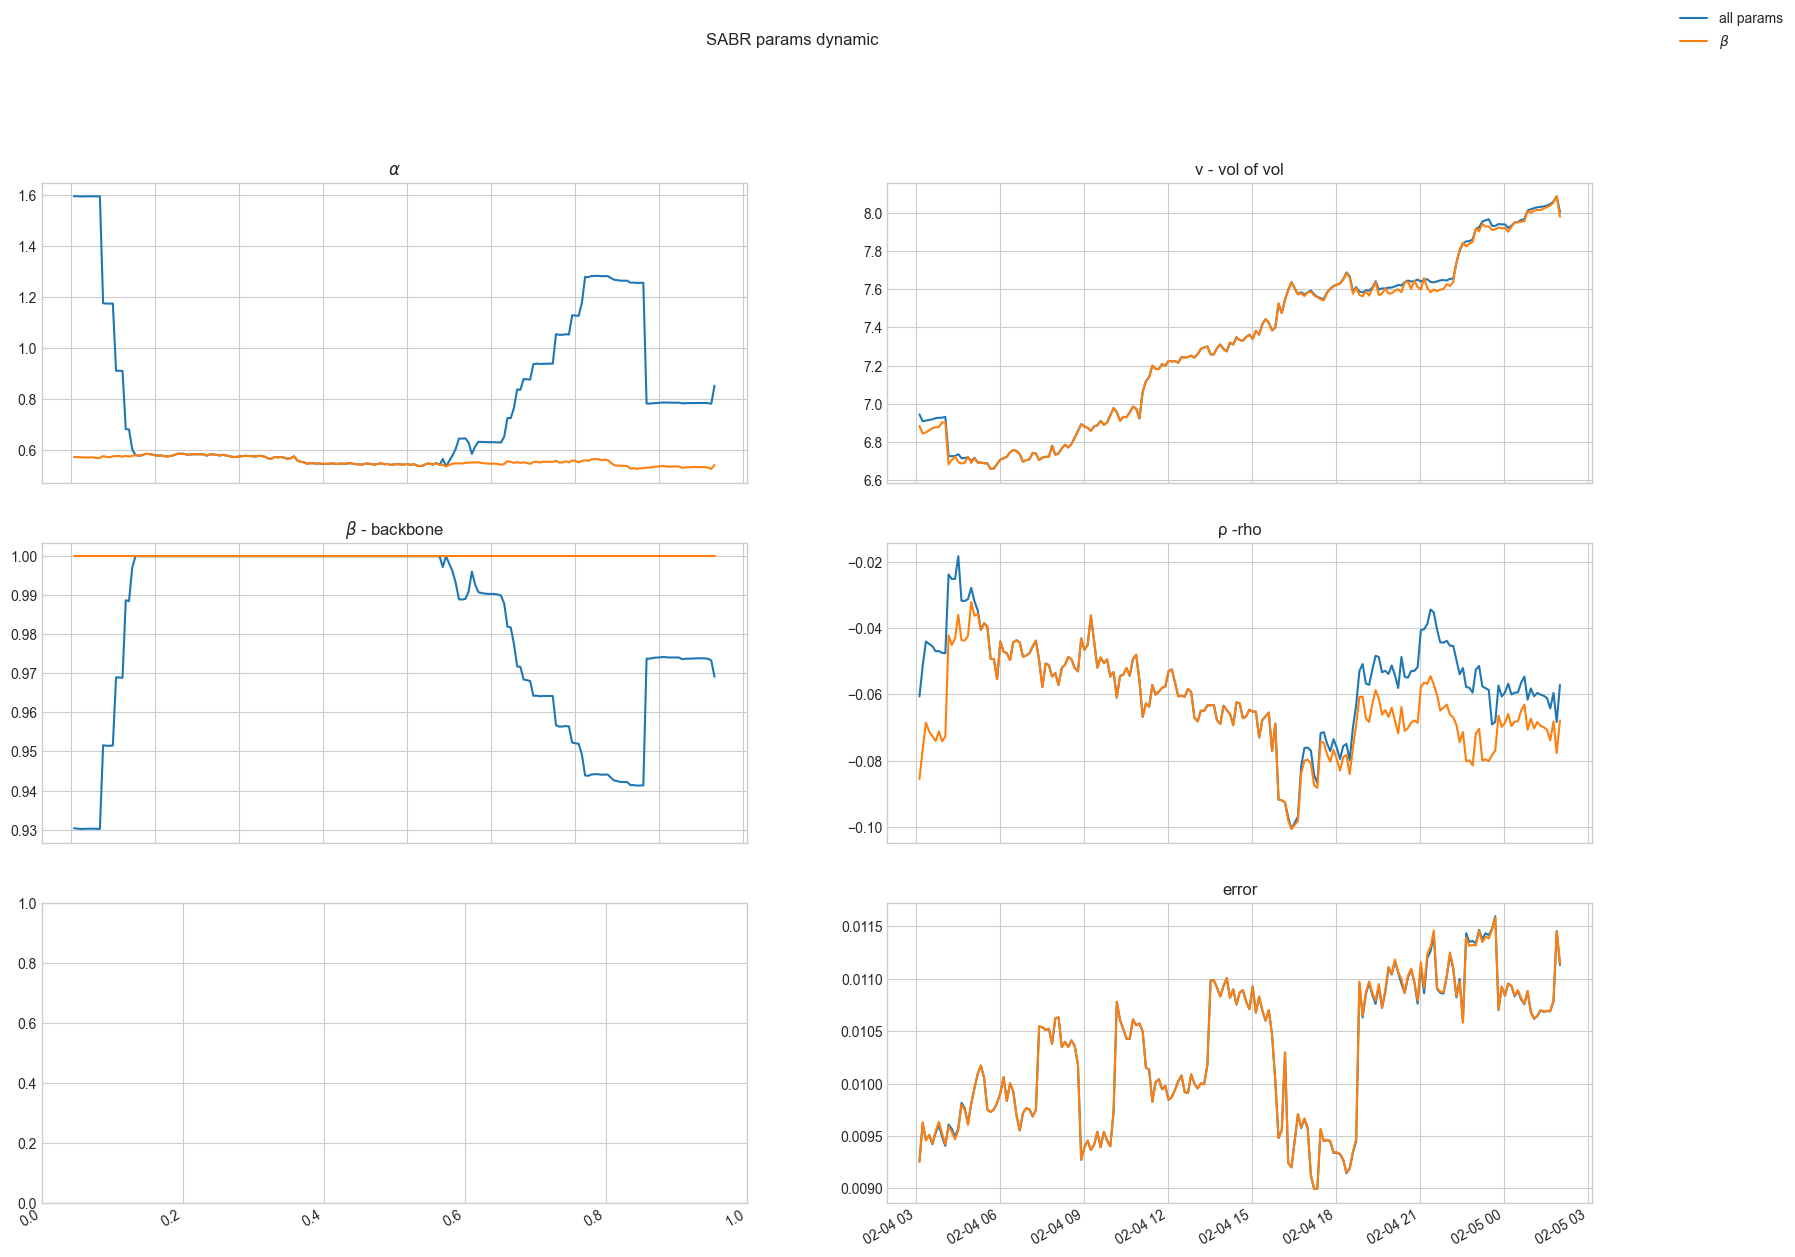

In [6]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0], label = "all params")
axs[0, 1].plot(timestamps_hm, params_all[1])
axs[1, 0].plot(timestamps_hm, params_all[2])
axs[1, 1].plot(timestamps_hm, params_all[3])
axs[2, 1].plot(timestamps_hm, errors_all)

axs[0, 0].plot(timestamps_hm, params_beta[0], label = r"$\beta$")
axs[0, 1].plot(timestamps_hm, params_beta[1])
axs[1, 0].plot(timestamps_hm, params_beta[2])
axs[1, 1].plot(timestamps_hm, params_beta[3])
axs[2, 1].plot(timestamps_hm, errors_beta)


axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")
axs[2, 1].set_title("error")



# for i in range(3):
#     for j in range(2):
#         for exp in expirarions:
#             axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
#             if i == j == 0:
#                 axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = exp)
#                 pass


plt.figlegend() 
fig.suptitle("SABR params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Vol smile

In [9]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0].timestamp
print(needed_stamp)

1675238986684000


In [10]:
alpha = np.float64(1.0)  # 
v = np.float64(1.3)  # 
beta = np.float64(0.5)  # 
rho = np.float64(-0.1)  # 

start_params = np.array([alpha, v, beta, rho])

pars_all, err_all, C_all = calibrate_sabr(df = df_only_exp, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "all")

pars_beta, err_beta, C_beta = calibrate_sabr(df = df_only_exp, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "beta")


    

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")

print("Beta:")
print(round_params(pars_beta))
print(err_beta)


All:
[7.797, 13.759, 0.839, -0.014]
0.008650310962127929
   
Beta:
[0.741, 13.646, 1.0, -0.056]
0.008173401083313516


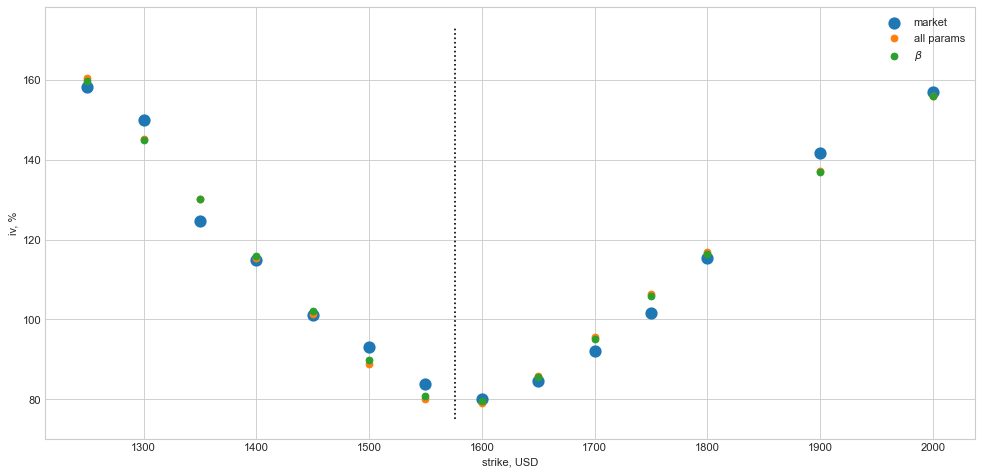

In [11]:
figure(figsize=(15, 7), dpi=80)


plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min()-5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()